# Filering File Sizes

##### The purpose in this code is to reduce computation time by filtering the files that need to be read for analysis. This will be done by reducing the number of timestamps that need to be opened by filtering the timestamps by mean precipitation and the number of pixels per timestamp that contain precipitation. Analysis will be carried out in the time series and histograms within to determine the thresholds for filtering. 

### Import Necessary Modules 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
from scipy.stats import gaussian_kde
import numpy.ma as ma
import math

### Time Range

In [3]:
startd = "2020-01-01T00:00"
endd = "2020-12-31T23:00"

### Set-up Cluster

##### Remember that this cluster will only last 30 minutes. Use the resart cell below to resart if resources are lost.

In [5]:
from dask.distributed import Client, LocalCluster

In [6]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=16,memory="32GB")
client = Client(cluster)

#### Scale Cluster

In [7]:
#cluster.adapt(min=24,max=256)
cluster.scale(cores=128)

In [8]:
cluster

### Client Restart:

In [ ]:
client.restart()

In [9]:
freq = '10T'
files_date = pd.date_range(startd, endd, freq=freq, closed='right')
sample_data = '/g/data/dt55/rainfields/prcp-m60/310'
full_list_files = sample_data + files_date.strftime("/%Y/%m/%d/*%Y%m%d_%H%M00*.nc")

my_files = []
for fn in full_list_files:
    fn = glob.glob(fn)
    if fn:
        my_files.append(fn[0])

In [10]:
def preprocess_radar(ds):
    if 'valid_time' not in ds.coords:
        ds = ds.assign_coords(
            valid_time=ds.valid_time).expand_dims('valid_time')
    return ds

In [11]:
# open input netcdf
input_radar_ds = xr.open_mfdataset(
    my_files,
    combine='nested',
    concat_dim='valid_time',
    parallel=True,
    lock=False,
    preprocess=preprocess_radar)

In [12]:
## Some useful functions
# Make a Cartopy Projection Object from netcdf Proj info
def get_ccrs_from_proj(ds):
    import cartopy.crs as ccrs
    if 'proj' in ds.variables:
        try:
            return ccrs.AlbersEqualArea(central_longitude=ds.proj.attrs['longitude_of_central_meridian'],
                            central_latitude=ds.proj.attrs['latitude_of_projection_origin'],
                            false_easting=ds.proj.attrs['false_easting'],
                            false_northing=ds.proj.attrs['false_northing'],
                            standard_parallels=ds.proj.attrs['standard_parallel'],
                            globe=None)
        except Exception as err:
            print(err)
            return ccrs.PlateCarree()


# define color table for RF3
class cmap_rf3(object):
    """Define color maps for RF3 rainfall products."""

    from matplotlib.colors import ListedColormap
    import matplotlib.pyplot as plt

    # RAINFALL
    rainfall_colors = np.array([(255, 255, 255),  # 0.0
                                (245, 245, 255),  # 0.2
                                (180, 180, 255),  # 0.5
                                (120, 120, 255),  # 1.5
                                (20,  20, 255),  # 2.5
                                (0, 216, 195),  # 4.0
                                (0, 150, 144),  # 6.0
                                (0, 102, 102),  # 10
                                (255, 255,   0),  # 15
                                (255, 200,   0),  # 20
                                (255, 150,   0),  # 30
                                (255, 100,   0),  # 40
                                (255,   0,   0),  # 50
                                (200,   0,   0),  # 60
                                (120,   0,   0),  # 75
                                (100,   0,   0)])  # > 100
    rainfall_colors = rainfall_colors/255.
    #cm_rainfall = 'blues'
    cm_rainfall = ListedColormap(rainfall_colors, 'blues')
    rainfall_levels = [600., 700, 800, 900, 1000,
                          1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200]        
    rainfall_levels_hr = [600., 700, 800, 900, 1000,
                          1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200]        
    rainfall_levels_10min = [600., 700, 800, 900, 1000,
                          1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200]  
    rainfall_levels_m = [0,20,40,60,80,100,120,140,160,180,200,220,240,260]
        
def transform_coords_from_km_to_m(ds):
    """Transform coords from km to m (if required)."""
    if ds is not None:
        if 'x' in ds.coords:
            if 'units' in ds.x.attrs:
                if ds.x.units == 'km':
                    ds['x'] = ds.x*1000.
                    ds.x.attrs.update({'units': 'm'})
                    ds.x.attrs.update(
                        {'standard_name':
                         'projection_x_coordinate'})
                    message = '; Original coords x transformed to m from km'
                    if 'history' in ds.attrs:
                        ds.attrs['history'] += message
                    else:
                        ds.attrs['history'] = message
                if ds.y.units == 'km':
                    ds['y'] = ds.y*1000.
                    ds.y.attrs.update({'units': 'm'})
                    ds.y.attrs.update(
                        {'standard_name':
                         'projection_y_coordinate'})
                    ds.attrs['history'] += '; Original coords y transformed to m from km'
    return ds

def preprocess_radar(ds):
    ds = transform_coords_from_km_to_m(ds)
    if 'n2' in ds.dims:
        ds = ds.drop_dims('n2')
    return ds

def get_projection_from_dataset(rainfall):
    """Return a cartopy projection object from a dataset."""
    try:
        if ('proj' in rainfall.data_vars):
            proj = rainfall.variables['proj']
            if (proj.attrs['grid_mapping_name'] ==
                    "albers_conical_equal_area"):
                projection = ccrs.AlbersEqualArea(
                    central_longitude=proj.attrs['longitude_of_central_meridian'],
                    central_latitude=proj.attrs['latitude_of_projection_origin'],
                    standard_parallels=proj.attrs['standard_parallel'],
                    )
            elif (getattr(proj, 'grid_mapping_name') ==
                    "gnomonic"):
                print('Projection is gnomonic')
                projection = ccrs.Gnomonic(
                    central_longitude=proj.attrs['longitude_of_projection_origin'],
                    central_latitude=proj.attrs['latitude_of_projection_origin'],
                    )
        else:
            print("INFO: Assuming standard PlateCarree projection")
            projection = ccrs.PlateCarree()
        return projection
    except Exception as err:
        print(err)
        return None

def get_coords_from_dataset(rainfall):
    """Return coordinates in a dataset."""
    try:
        if ('lat' in rainfall.coords):
            x = rainfall['lon'][:].data
            y = rainfall['lat'][:].data
        elif ('x' in rainfall.coords):
            x = rainfall['x'][:].data
            y = rainfall['y'][:].data
            if (rainfall['x'].units == 'km'):
                factor = 1000.
                x = x * factor
                y = y * factor
        else:
            x = np.array(None)
            y = np.array(None)
        return x, y
    except Exception as err:
        print(err)
        return None, None

In [13]:
radar_data=transform_coords_from_km_to_m(input_radar_ds)

# Brisbane T15-Brisbane_projection
# Sydney T21-Sydney_projection
# Cairns T09-Cairns_projection

##### To make things quicker, just change the file and nothing else

In [14]:
T15='/g/data/dt55/pst/projection/PST_tile_T15-Brisbane_projection.nc'
T15_tile_ds=xr.open_dataset(T15)

In [15]:
_, T15_fix = xr.align(T15_tile_ds,radar_data,join='left',)

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.06/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [16]:
T15_acc=T15_fix.sum(['valid_time'])

In [17]:
target_proj = get_projection_from_dataset(T15_fix)

In [18]:
target_x_points, target_y_points = get_coords_from_dataset(T15_fix)
coord_x_grid_target, coord_y_grid_target = np.meshgrid(target_x_points,
                                                           target_y_points)
proj_info = radar_data.proj.copy()

In [19]:
source_proj = get_projection_from_dataset(source_ds)
target_xyz = source_proj.transform_points(target_proj,
                                              coord_x_grid_target,
                                              coord_y_grid_target,
                                              )
# store new coordinates in the source projection
# as DataArray

new_y = xr.DataArray(target_xyz[:, :, 1],
                     dims=["y","x"],
                     coords={"x": target_x_points,"y":target_y_points})
new_x = xr.DataArray(target_xyz[:, :, 0],
                     dims=["y","x"],
                     coords={"x": target_x_points,"y":target_y_points})

INFO: Assuming standard PlateCarree projection


# Defining 'Rainy' Hours

#### Filtering by Mean

In [21]:
T15_hour_mean = T15_fix.precipitation.mean(['x','y']).compute()

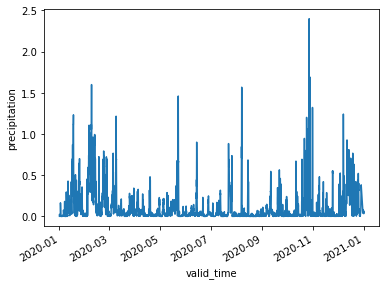

In [89]:
_=T15_hour_mean.plot()

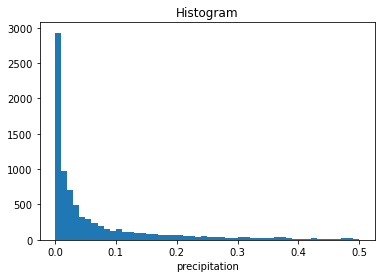

In [90]:
_=T15_hour_mean.plot.hist(bins=50,range=[0,0.5])

##### Most values above 0.01. We can verifiy by looking at the time series that this removes the dries days. We have to be careful with mean not to cause an exclusion of small localised, but heavy storms.

#### Filtering by Pixel Count

In [22]:
T15_hour_count_thr = T15_fix.precipitation.where(T15_fix.precipitation > 0.1).count(['x','y']).compute()

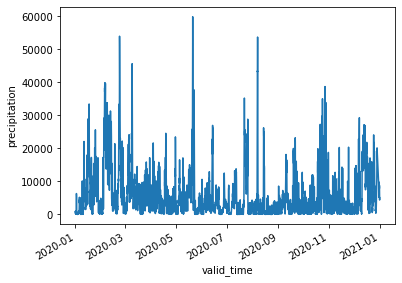

In [92]:
T15_hour_count_thr.plot()

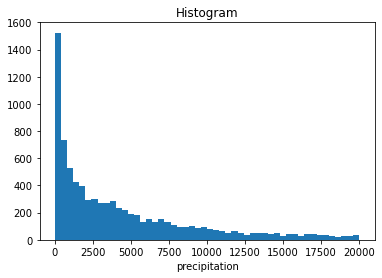

In [93]:
_=T15_hour_count_thr.plot.hist(bins=50,range=[0,20000])

##### For Brisbane I chose 7000. We can see on the histogram that this is where the curve starts to flattern out. Looking back at the time series we see that this still a comparably low value but cuts out a lot of lower values.

#### Reduce by Count

##### This will filter the data set by count and exclude timestamps with less than 7000 pixels of precipitation.

In [23]:
T15_hour_rain_pix_count = T15_fix.where(T15_hour_count_thr>7000).dropna('valid_time', how='all')

In [ ]:
T15_hour_rain_pix_count 

#### Further Reduce by Mean

##### This will filter the data set by mean and exclude timestamps where the mean precipitation is less than 0.01mm.

In [24]:
T15_hour_rain_pix_mean = T15_hour_rain_pix_count.where(T15_hour_mean>0.01).dropna('valid_time', how='all')

In [ ]:
T15_hour_rain_pix_mean

## Save File

#### Filter by Count

##### This will save a list of the time steps filtered by count.

In [25]:
T15_hour_rain_pix_count_timestamps = T15_hour_rain_pix_count.valid_time.values

In [26]:
pd.DataFrame(T15_hour_rain_pix_count_timestamps)

0
0    2020-01-09 08:00:00
1    2020-01-09 09:00:00
2    2020-01-09 10:00:00
3    2020-01-09 11:00:00
4    2020-01-09 12:00:00
...                  ...
2381 2020-12-31 15:00:00
2382 2020-12-31 16:00:00
2383 2020-12-31 17:00:00
2384 2020-12-31 18:00:00
2385 2020-12-31 19:00:00

[2386 rows x 1 columns]

In [27]:
pd.DataFrame(T15_hour_rain_pix_count_timestamps).to_csv('/g/data/dt55/jm1356/data/T215_pix.csv')

### Filter by Count and Mean

##### This will save a list of the time steps filtered by count and then the mean. We would not really expect this to remove many (if any) more points but it may.

In [28]:
T15_hour_rain_pix_mean_timestamps = T15_hour_rain_pix_mean.valid_time.values

In [29]:
pd.DataFrame(T15_hour_rain_pix_mean_timestamps)

0
0    2020-01-09 08:00:00
1    2020-01-09 09:00:00
2    2020-01-09 10:00:00
3    2020-01-09 11:00:00
4    2020-01-09 12:00:00
...                  ...
2381 2020-12-31 15:00:00
2382 2020-12-31 16:00:00
2383 2020-12-31 17:00:00
2384 2020-12-31 18:00:00
2385 2020-12-31 19:00:00

[2386 rows x 1 columns]

#### % Reduction

In [30]:
(len(T15_hour_rain_pix_mean_timestamps)/8760)*100

27.237442922374427

In [31]:
pd.DataFrame(T15_hour_rain_pix_mean_timestamps).to_csv('/g/data/dt55/jm1356/data/T15_pix_mean.csv')